In [1]:
from cProfile import label
from PIL import Image
import os
import matplotlib.pyplot as plt
import matplotlib.image as pmimg
import numpy as np
import nibabel as nib
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow

# https://github.com/zhixuhao/unet

In [2]:
os.chdir("iSeg-2017-Training/")

# Fonctions utiles

def fast_display(*img2dlst):
    plt.figure(figsize=(16, 8))
    nbImg = len(img2dlst)
    cols = min(9, nbImg)
    rows = (nbImg // cols) + 1
    for jaaj, img2d in enumerate(img2dlst):
        plt.subplot(rows, cols, jaaj + 1)
        plt.imshow(img2d)
    plt.show()

def print_slices(img):
    sx, sy, sz, _ = img.shape
    fast_display(img[sx//2, :, :, 0], img[sy//2, :, :, 0], img[sz//2, :, :, 0])

# calcul des différences entre 2 images (dice)
def compute_dice(X, Y):
    Xbin = (X > 0)
    Ybin = (Y > 0)
    cardIntersec = np.sum(np.logical_and(Xbin, Ybin))
    cardX = np.sum(Xbin)
    cardY = np.sum(Ybin)
    print("cardIntersec = ", cardIntersec)
    print("cardX = ", cardX)
    print("cardY = ", cardY)
    if cardX + cardY > 0:
        dice = (2.0 * cardIntersec)/(cardX + cardY)
        print("dice = ", dice)
        return dice
    else:
        return 0

# normalisation des valeurs dans une image
def normalisation(img):
    nu = np.mean(img[img > 0])
    sigma = np.std(img[img > 0])
    return ((img - nu)/sigma)

T1 : coupes sagittales, coronales, axiales de subject-1-label.img


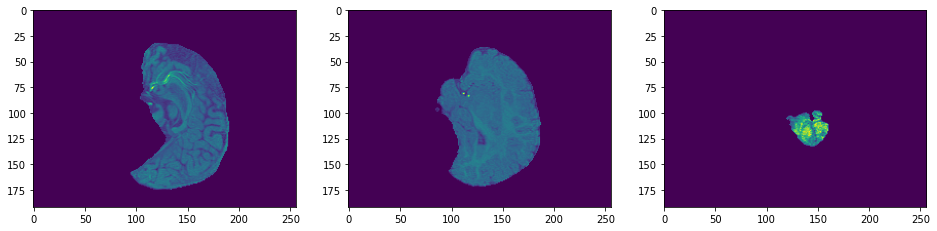

T2 : coupes sagittales, coronales, axiales de subject-1-label.img


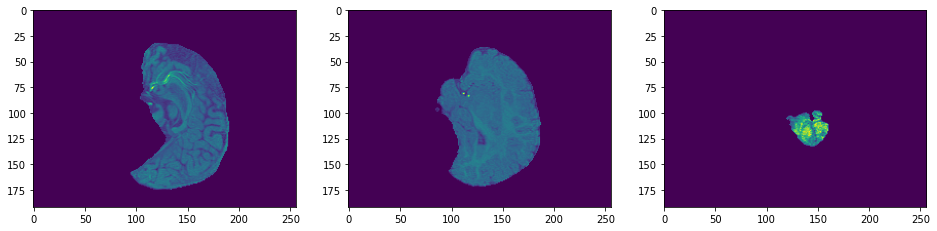

Labels : coupes sagittales, coronales, axiales de subject-1-label.img


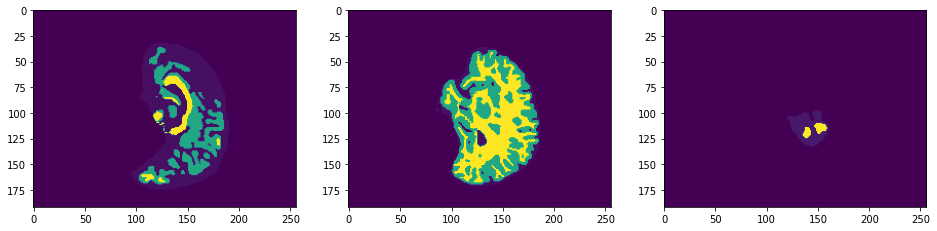

Nombre total de patients :  10


In [3]:
nombre_total_de_patients = 0
for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        if filename[0] == '.':
            continue

        if "label" in filename and "hdr" not in filename:
            nomT1 = filename[:-10] + "-T1.img"
            T1 = nib.load(nomT1).get_fdata()
            if nombre_total_de_patients == 0:
                print("T1 : coupes sagittales, coronales, axiales de " + filename)
                print_slices(T1)
            
            nomT2 = filename[:-10] + "-T2.img"
            T2 = nib.load(nomT1).get_fdata()
            if nombre_total_de_patients == 0:
                print("T2 : coupes sagittales, coronales, axiales de " + filename)
                print_slices(T2)
            
            labels = nib.load(filename).get_fdata()
            if nombre_total_de_patients == 0:
                print("Labels : coupes sagittales, coronales, axiales de " + filename)
                print_slices(labels)
            
            nombre_total_de_patients += 1

print("Nombre total de patients : ", nombre_total_de_patients)

nombre_patients_training = 6
nombre_patients_validation = 2
nombre_patients_test = 2

In [4]:
# PART 1 ------------------------------------------------------------------

seuilaire = 100

nombre_slices_pertinents_training = 0
nombre_slices_pertinents_validation = 0

numpatient = 0
for dirname, _, filename in os.walk("./"):
    for filename in filenames:
        if filename[0] == '.':
            continue

        if "label" in filename and "hdr" not in filename:

            if numpatient < nombre_patients_training:
                print("Patient training : " + filename)
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                for z in range (0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        nombre_slices_pertinents_training += 1
            
            if numpatient >= nombre_patients_training and numpatient < nombre_patients_training + nombre_patients_validation:
                print("Patient (validation) : " + filename)
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        nombre_slices_pertinents_validation += 1
            
            numpatient += 1

print("nombre_slices_pertinents_training = ", nombre_slices_pertinents_training)
print("nombre_slices_pertinents_validation = ", nombre_slices_pertinents_validation)

xtrain = np.zeros((nombre_slices_pertinents_training, sx, sy, 2))
ytrain = np.zeros((nombre_slices_pertinents_training, sx, sy, 1))

xvalidation = np.zeros((nombre_slices_pertinents_validation, sx, sy, 2))
yvalidation = np.zeros((nombre_slices_pertinents_validation, sx, sy, 1))

numero_slice_pertinent_training = 0
numero_slice_pertinent_validation = 0
numpatient = 0

for dirname, _, filename in os.walk("./"):
    for filename in filenames:
        if filename[0] == '.':
            continue

        if "label" in filename and "hdr" not in filename:

            if numpatient < nombre_patients_training:
                print("Patient (training) : " + filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                T1normalise = normalisation(T1).reshape((sx, sy, sz))
                T2normalise = normalisation(T2).reshape((sx, sy, sz))
                labelsclipped = np.clip(labels, 0, 1).reshape((sx, sy ,sz))

                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        xtrain[numero_slice_pertinent_training, :, :, 0] = T1normalise[:, :, z]
                        xtrain[numero_slice_pertinent_training, :, :, 1] = T2normalise[:, :, z]
                        ytrain[numero_slice_pertinent_training, :, :, 0] = labelsclipped[:, :, z]
                        numero_slice_pertinent_training += 1
            
            if numpatient >= nombre_patients_training and numpatient < nombre_patients_training + nombre_patients_validation:
                print("Patient (validation) : " + filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                T1normalise = normalisation(T1).reshape((sx, sy, sz))
                T2normalise = normalisation(T2).reshape((sx, sy, sz))
                vt3d = np.where(labels >= 10, 1, 0)

                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        xvalidation[numero_slice_pertinent_validation, :, :, 0] = T1normalise[:, :, z]
                        xvalidation[numero_slice_pertinent_validation, :, :, 1] = T2normalise[:, :, z]
                        yvalidation[numero_slice_pertinent_validation, :, :, 0] = vt3d[:, :, z]
                        numero_slice_pertinent_validation += 1
            
            numpatient += 1

print(np.unique(labels))

Patient training : subject-1-label.img
Patient training : subject-10-label.img
Patient training : subject-2-label.img
Patient training : subject-3-label.img
Patient training : subject-4-label.img
Patient training : subject-5-label.img
Patient (validation) : subject-6-label.img
Patient (validation) : subject-7-label.img
nombre_slices_pertinents_training =  1536
nombre_slices_pertinents_validation =  512
Patient (training) : subject-1-label.img
Patient (training) : subject-10-label.img
Patient (training) : subject-2-label.img
Patient (training) : subject-3-label.img
Patient (training) : subject-4-label.img
Patient (training) : subject-5-label.img
Patient (validation) : subject-6-label.img
Patient (validation) : subject-7-label.img
[  0.  10. 150. 250.]


In [5]:
# ---- code relatif à la première IA ----

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet_step1(input_size = (sx, sy, 2)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])
    model.summary()

    return model

model_step1 = unet_step1(input_size = (sx, sy, 2))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 144, 192, 2  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 144, 192, 8)  152         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 144, 192, 8)  584         ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 72, 96, 8)    0           ['conv2d_1[0][0]']           

 conv2d_21 (Conv2D)             (None, 144, 192, 64  36928       ['conv2d_20[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_22 (Conv2D)             (None, 144, 192, 2)  1154        ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_23 (Conv2D)             (None, 144, 192, 1)  3           ['conv2d_22[0][0]']              
                                                                                                  
Total params: 7,907,845
Trainable params: 7,907,845
Non-trainable params: 0
__________________________________________________________________________________________________


In [6]:
# ---- entrainement de l'IA 1 ----

DO_WE_LEARN = False
epochs = 20

if DO_WE_LEARN:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model_step1.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 1,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model_step1.save_weights("model_step1.hdf5")
else:
    model_step1.load_weights("model_step1.hdf5")

liste_dices_crane = np.zeros((nombre_patients_test,))

PATIENT (test):  subject-1-label.img
T1, T2, Prédiction, Vérité terrain


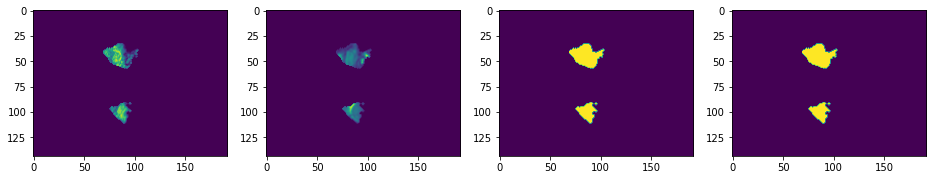

T1, T2, Prédiction, Vérité terrain


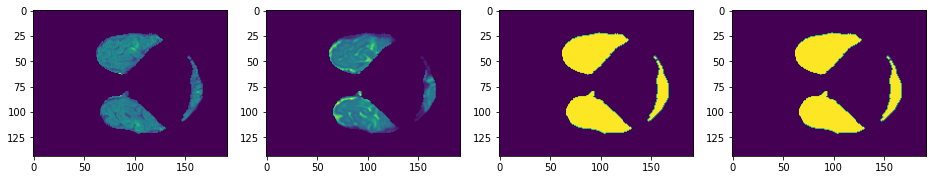

T1, T2, Prédiction, Vérité terrain


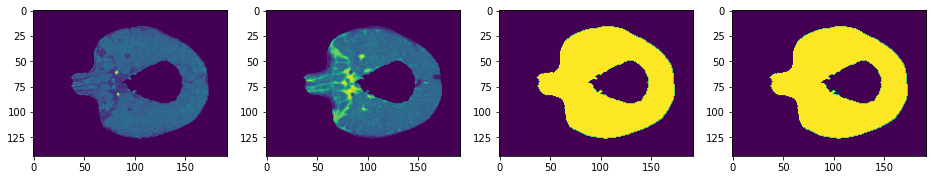

T1, T2, Prédiction, Vérité terrain


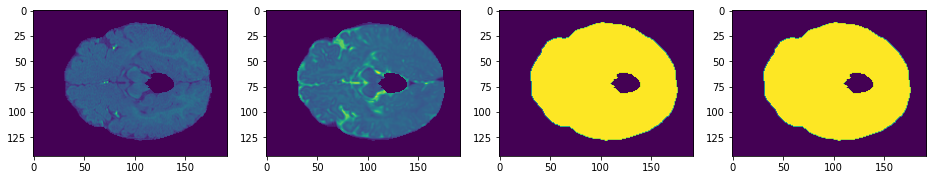

T1, T2, Prédiction, Vérité terrain


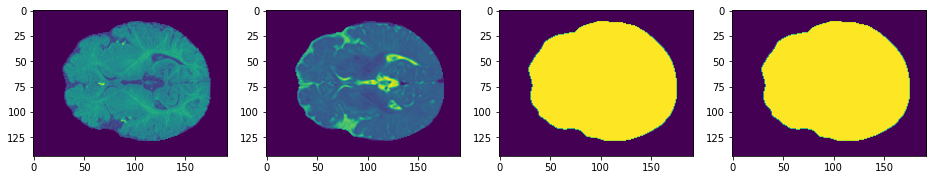

T1, T2, Prédiction, Vérité terrain


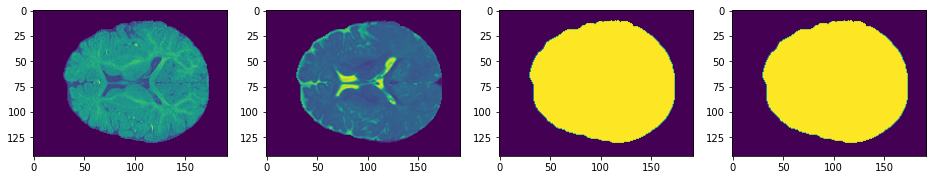

T1, T2, Prédiction, Vérité terrain


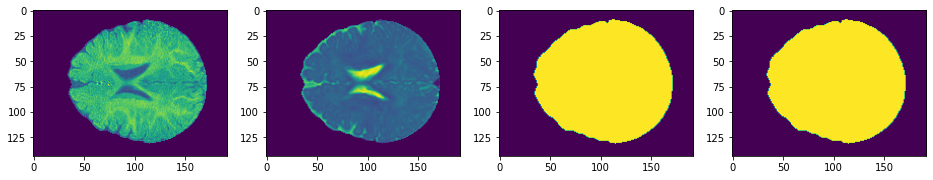

T1, T2, Prédiction, Vérité terrain


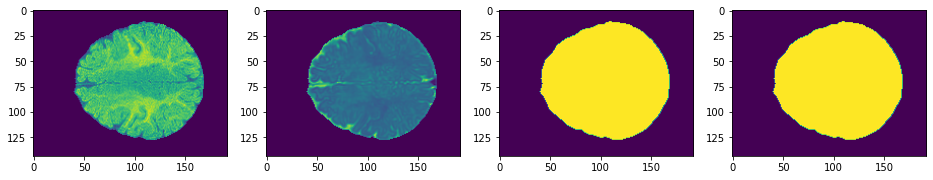

T1, T2, Prédiction, Vérité terrain


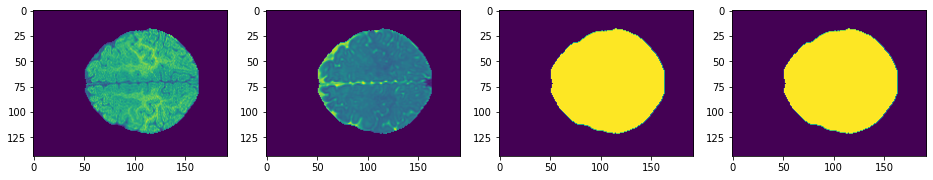

T1, T2, Prédiction, Vérité terrain


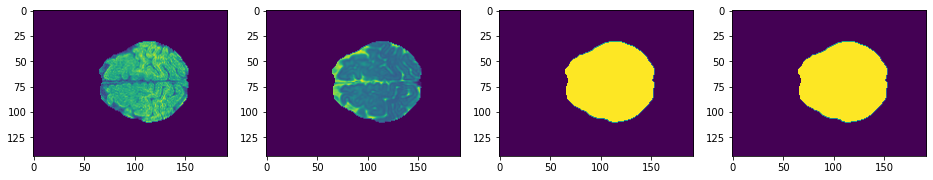

T1, T2, Prédiction, Vérité terrain


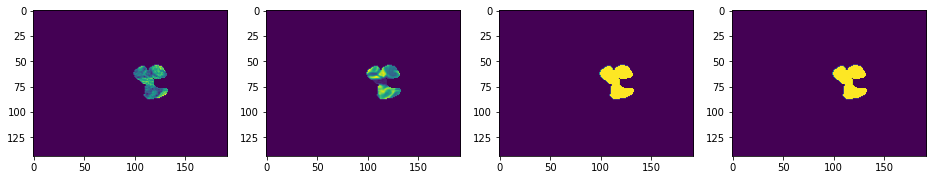

cardIntersec =  921402
cardX =  921410
cardY =  921422
dice =  0.9999848059942523
PATIENT (test):  subject-10-label.img
T1, T2, Prédiction, Vérité terrain


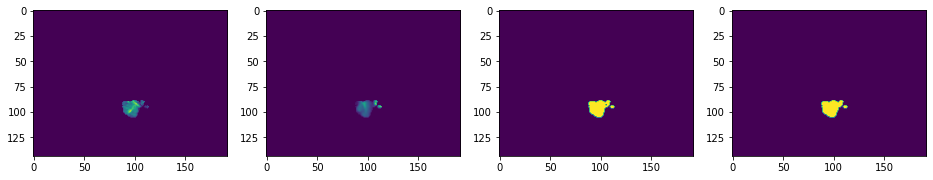

T1, T2, Prédiction, Vérité terrain


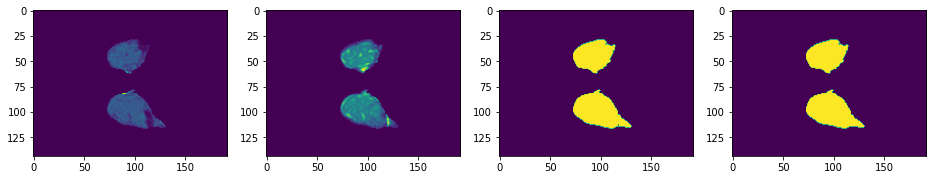

T1, T2, Prédiction, Vérité terrain


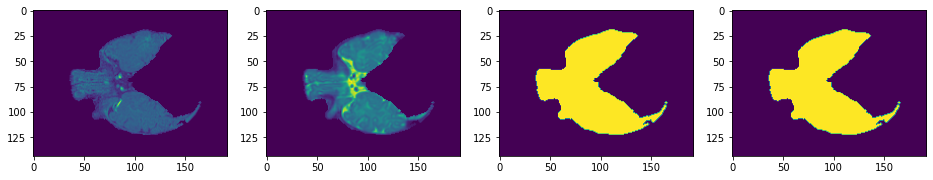

T1, T2, Prédiction, Vérité terrain


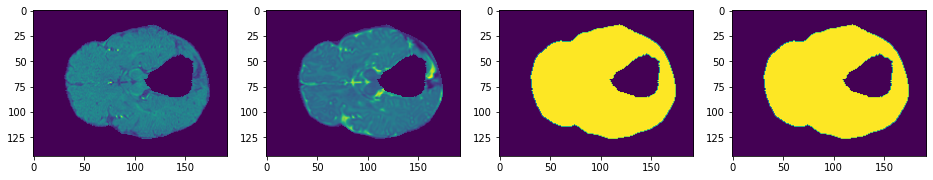

T1, T2, Prédiction, Vérité terrain


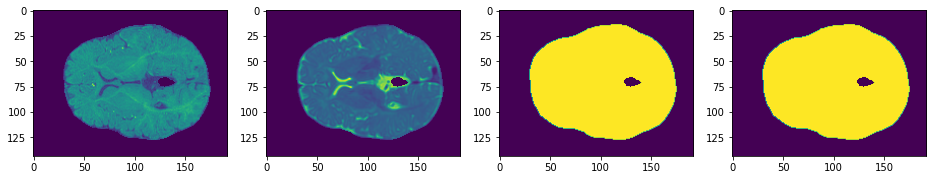

T1, T2, Prédiction, Vérité terrain


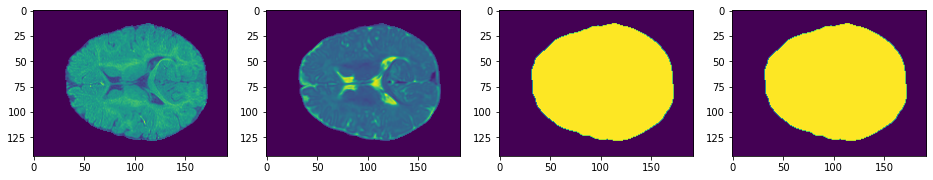

T1, T2, Prédiction, Vérité terrain


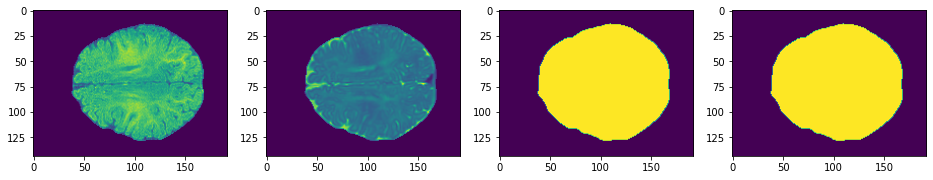

T1, T2, Prédiction, Vérité terrain


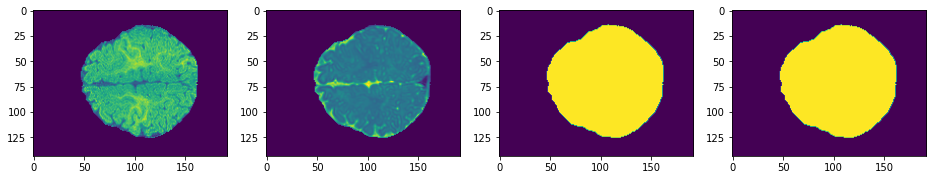

T1, T2, Prédiction, Vérité terrain


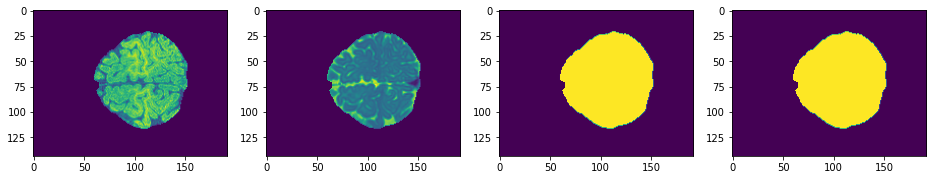

T1, T2, Prédiction, Vérité terrain


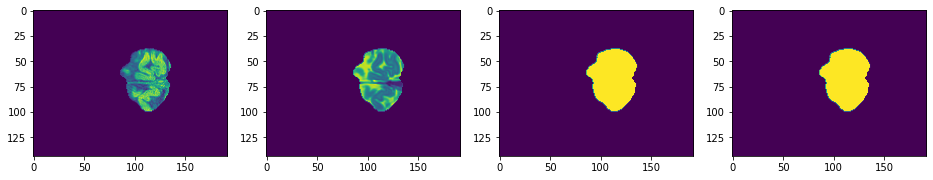

cardIntersec =  747264
cardX =  747264
cardY =  747308
dice =  0.9999705601336034


In [7]:
# Inférence 1

numpatient = 0
num_patient_test = 0
for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        if "label" in filename and "hdr" not in filename:
            if numpatient <= nombre_patients_training + nombre_patients_validation and numpatient < nombre_patients_test:
                print("PATIENT (test): ", filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()

                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))

                prediction3D_10 = np.zeros((sx, sy, sz))

                T1NORMALISE = normalisation(T1).reshape((sx, sy, sz))
                T2NORMALISE = normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0)

                for z in range(0, sz):
                    inputreseau = np.zeros((1, sx, sy,2))
                    inputreseau[0, :, :, 0] = T1NORMALISE[:, :, z]
                    inputreseau[0, :, :, 1] = T2NORMALISE[:, :, z]
                    prediction10 = np.round(model_step1.predict(inputreseau, verbose = False).reshape((sx, sy)))
                    prediction3D_10[:, :, z] = np.copy(prediction10)

                    prediction_to_plot = np.copy(prediction10)
                    VT_to_plot = np.copy(VT10[:, :, z])
                    if z % 10 == 0 and np.sum(VT_to_plot) > 0:
                        VT_to_plot[0, 0] = 1.0
                        prediction_to_plot[0, 0] = 1.0
                        print("T1, T2, Prédiction, Vérité terrain")
                        fast_display(
                            T1NORMALISE[:, :, z].reshape((sx, sy)),
                            T2NORMALISE[:, :, z].reshape((sx, sy)),
                            prediction10,
                            VT_to_plot)
                
                dice = compute_dice(prediction3D_10, VT10)
                liste_dices_crane[num_patient_test] = dice
                num_patient_test += 1
            
            numpatient += 1

In [8]:
# PART 2 ------------------------------------------------------------------

nombre_slices_pertinents_training = 0
nombre_slices_pertinents_validation = 0

numpatient = 0
for dirname, _, filename in os.walk("./"):
    for filename in filenames:
        if filename[0] == '.':
            continue

        if "label" in filename and "hdr" not in filename:

            if numpatient < nombre_patients_training:
                print("Patient training : " + filename)
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                for z in range (0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        nombre_slices_pertinents_training += 1
            
            if numpatient >= nombre_patients_training and numpatient < nombre_patients_training + nombre_patients_validation:
                print("Patient (validation) : " + filename)
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        nombre_slices_pertinents_validation += 1
            
            numpatient += 1

print("nombre_slices_pertinents_training = ", nombre_slices_pertinents_training)
print("nombre_slices_pertinents_validation = ", nombre_slices_pertinents_validation)

xtrain = np.zeros((nombre_slices_pertinents_training, sx, sy, 3))
ytrain = np.zeros((nombre_slices_pertinents_training, sx, sy, 1))

xvalidation = np.zeros((nombre_slices_pertinents_validation, sx, sy, 3))
yvalidation = np.zeros((nombre_slices_pertinents_validation, sx, sy, 1))

numero_slice_pertinent_training = 0
numero_slice_pertinent_validation = 0
numpatient = 0

for dirname, _, filename in os.walk("./"):
    for filename in filenames:
        if filename[0] == '.':
            continue

        if "label" in filename and "hdr" not in filename:

            if numpatient < nombre_patients_training:
                print("Patient (training) : " + filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                T1normalise = normalisation(T1).reshape((sx, sy, sz))
                T2normalise = normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0).reshape((sx, sy, sz))
                VT150 = np.where(labels >= 150, 1, 0).reshape((sx, sy, sz))

                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        xtrain[numero_slice_pertinent_training, :, :, 0] = T1normalise[:, :, z]
                        xtrain[numero_slice_pertinent_training, :, :, 1] = T2normalise[:, :, z]
                        xtrain[numero_slice_pertinent_training, :, :, 2] = VT10[:, :, z]
                        ytrain[numero_slice_pertinent_training, :, :, 0] = VT150[:, :, z]
                        numero_slice_pertinent_training += 1
            
            if numpatient >= nombre_patients_training and numpatient < nombre_patients_training + nombre_patients_validation:
                print("Patient (validation) : " + filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()
                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))
                T1normalise = normalisation(T1).reshape((sx, sy, sz))
                T2normalise = normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0).reshape((sx, sy, sz))
                VT150 = np.where(labels >= 150, 1, 0).reshape((sx, sy, sz))

                for z in range(0, sz):
                    slice = labels[:, :, z]
                    if np.sum(slice >= 0) >= seuilaire:
                        xvalidation[numero_slice_pertinent_validation, :, :, 0] = T1normalise[:, :, z]
                        xvalidation[numero_slice_pertinent_validation, :, :, 1] = T2normalise[:, :, z]
                        xvalidation[numero_slice_pertinent_validation, :, :, 2] = VT10[:, :, z]
                        yvalidation[numero_slice_pertinent_validation, :, :, 0] = VT150[:, :, z]
                        numero_slice_pertinent_validation += 1
            
            numpatient += 1

print(np.unique(labels))

Patient training : subject-1-label.img
Patient training : subject-10-label.img
Patient training : subject-2-label.img
Patient training : subject-3-label.img
Patient training : subject-4-label.img
Patient training : subject-5-label.img
Patient (validation) : subject-6-label.img
Patient (validation) : subject-7-label.img
nombre_slices_pertinents_training =  1536
nombre_slices_pertinents_validation =  512
Patient (training) : subject-1-label.img
Patient (training) : subject-10-label.img
Patient (training) : subject-2-label.img
Patient (training) : subject-3-label.img
Patient (training) : subject-4-label.img
Patient (training) : subject-5-label.img
Patient (validation) : subject-6-label.img
Patient (validation) : subject-7-label.img
[  0.  10. 150. 250.]


In [9]:
# ---- code relatif à la première IA ----

nbf64 = 8
nbf128 = 2 * nbf64
nbf256 = 2 * nbf128
nbf512 = 2 * nbf256
nbf1024 = 2 * nbf512

def unet_step2(input_size = (sx, sy, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(inputs)
    conv1 = Conv2D(nbf64, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool1)
    conv2 = Conv2D(nbf128, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool2)
    conv3 = Conv2D(nbf256, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool3)
    conv4 = Conv2D(nbf512, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(pool4)
    conv5 = Conv2D(nbf1024, 3, activation = "relu", padding = "same", kernel_initializer = "he_normal")(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = "binary_crossentropy", metrics = ["accuracy"])
    model.summary()

    return model

model_step2 = unet_step2(input_size = (sx, sy, 3))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 144, 192, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 144, 192, 8)  224         ['input_2[0][0]']                
                                                                                                  
 conv2d_25 (Conv2D)             (None, 144, 192, 8)  584         ['conv2d_24[0][0]']              
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 72, 96, 8)   0           ['conv2d_25[0][0]']        

 conv2d_45 (Conv2D)             (None, 144, 192, 64  36928       ['conv2d_44[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_46 (Conv2D)             (None, 144, 192, 2)  1154        ['conv2d_45[0][0]']              
                                                                                                  
 conv2d_47 (Conv2D)             (None, 144, 192, 1)  3           ['conv2d_46[0][0]']              
                                                                                                  
Total params: 7,907,917
Trainable params: 7,907,917
Non-trainable params: 0
__________________________________________________________________________________________________


In [10]:
# ---- entrainement de l'IA 2 ----

DO_WE_LEARN = False
epochs = 20

if DO_WE_LEARN:
    early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=2, mode='auto', baseline=None, restore_best_weights=True)

    history = model_step2.fit(
    verbose = 1,
    initial_epoch = 0,
    x = xtrain,
    y = ytrain,
    batch_size = 1,
    validation_data = (xvalidation, yvalidation),
    epochs = epochs,
    callbacks = [early_stopping]
    )
    model_step2.save_weights("model_step2.hdf5")
else:
    model_step2.load_weights("model_step2.hdf5")

liste_dices_crane = np.zeros((nombre_patients_test,))

PATIENT (test):  subject-1-label.img
1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


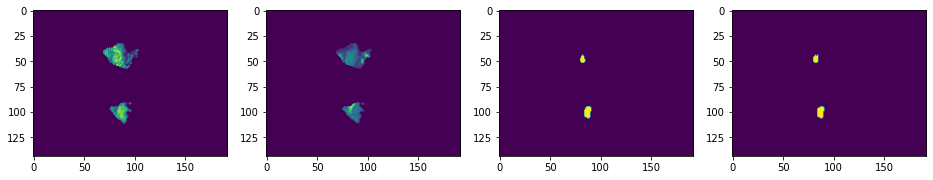

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


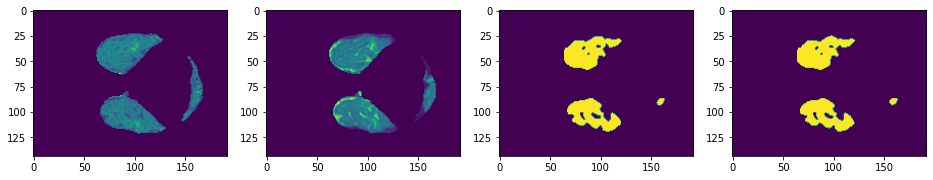

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


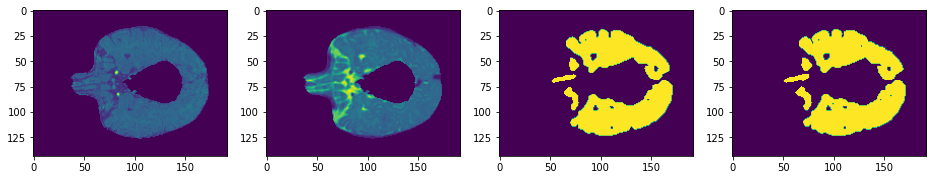

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


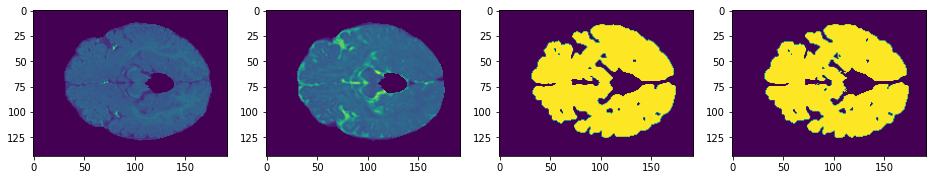

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


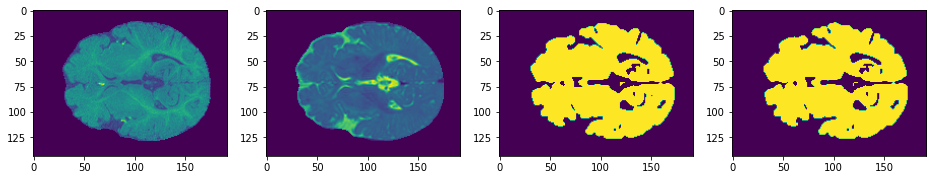

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


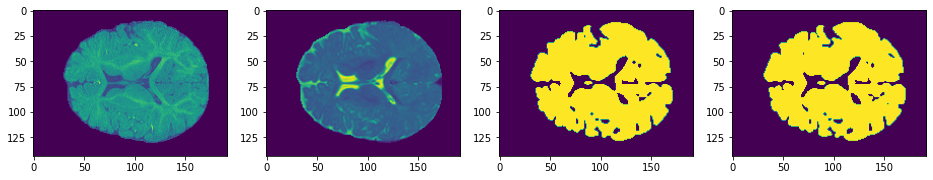

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


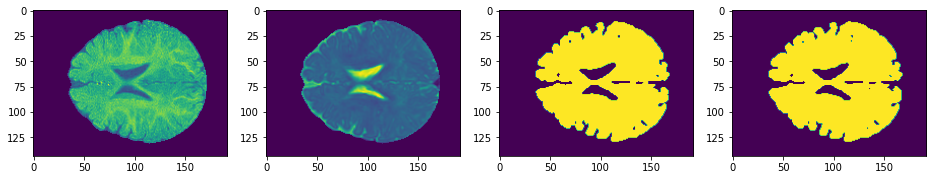

1/1 [==============================] - 0s 15ms/step
T1, T2, Prédiction, Vérité terrain


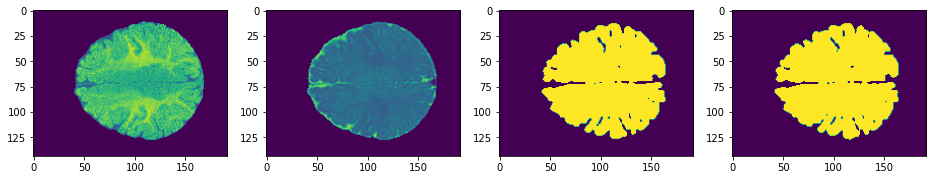

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


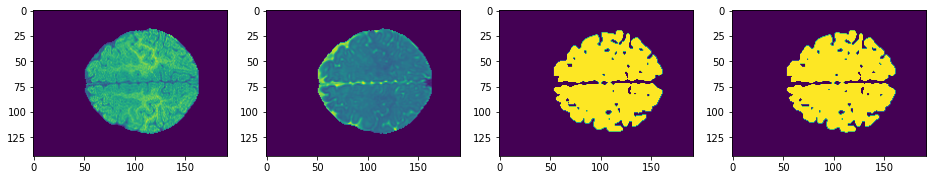

1/1 [==============================] - 0s 15ms/step
T1, T2, Prédiction, Vérité terrain


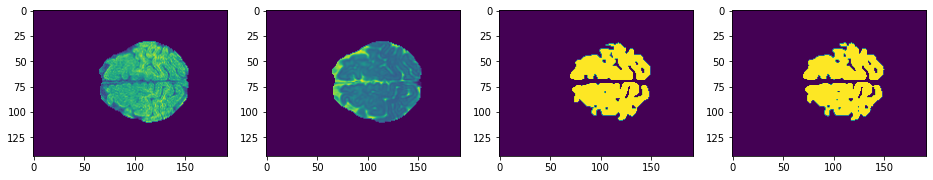

1/1 [==============================] - 0s 15ms/step
cardIntersec =  716073
cardX =  719786
cardY =  723271
dice =  0.9924389681072889
PATIENT (test):  subject-10-label.img
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
T1, T2, Prédiction, Vérité terrain


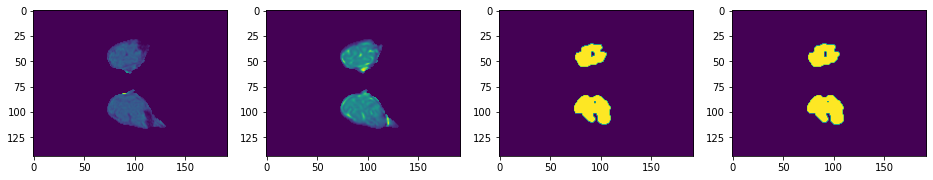

1/1 [==============================] - 0s 15ms/step
T1, T2, Prédiction, Vérité terrain


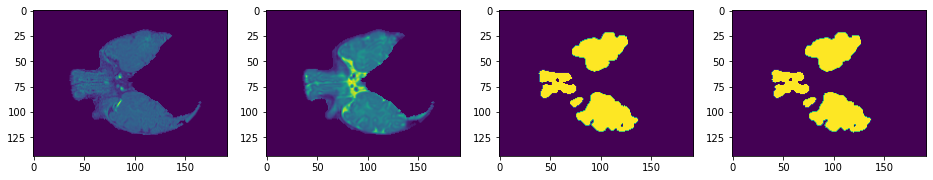

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


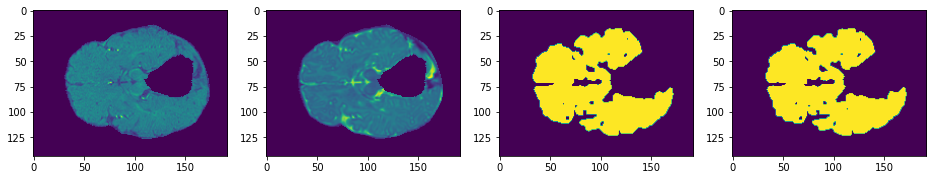

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


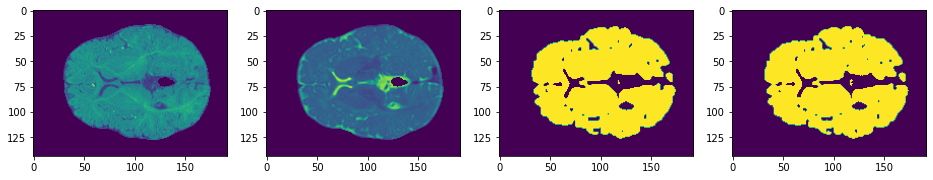

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


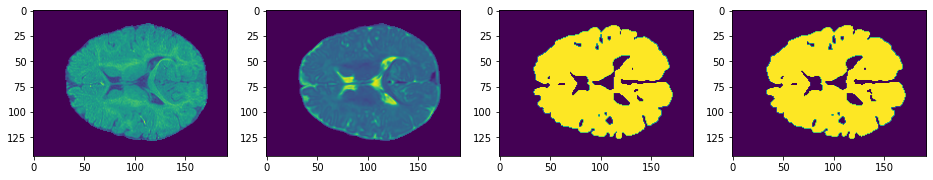

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


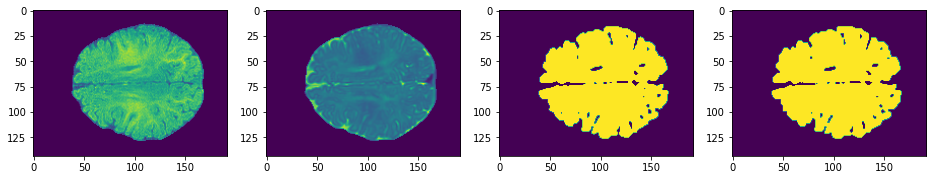

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


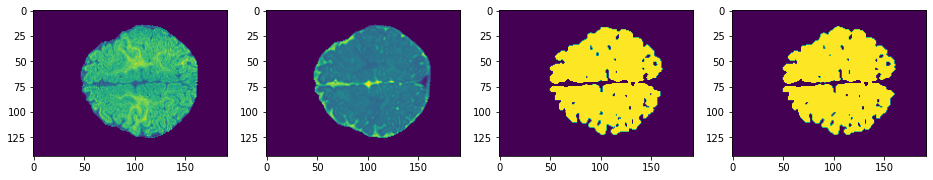

1/1 [==============================] - 0s 15ms/step
T1, T2, Prédiction, Vérité terrain


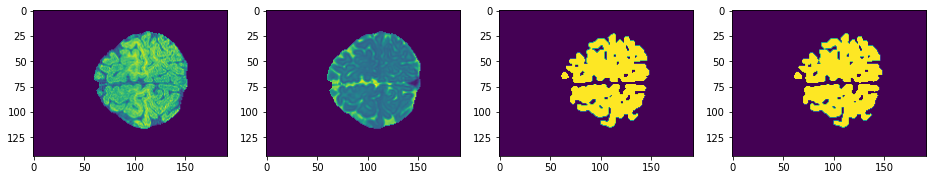

1/1 [==============================] - 0s 16ms/step
T1, T2, Prédiction, Vérité terrain


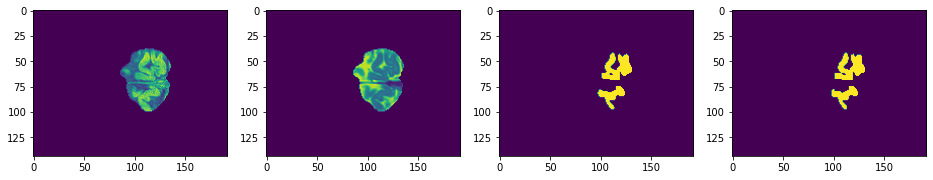

1/1 [==============================] - 0s 17ms/step
cardIntersec =  567389
cardX =  570751
cardY =  572978
dice =  0.9921738453777075


In [11]:
# Inférence 2

numpatient = 0
num_patient_test = 0
for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        if "label" in filename and "hdr" not in filename:
            if numpatient <= nombre_patients_training + nombre_patients_validation and numpatient < nombre_patients_test:
                print("PATIENT (test): ", filename)
                nomT1 = filename[:-10] + "-T1.img"
                T1 = nib.load(nomT1).get_fdata()
                nomT2 = filename[:-10] + "-T2.img"
                T2 = nib.load(nomT2).get_fdata()
                labels = nib.load(filename).get_fdata()

                sx, sy, sz, _ = labels.shape
                labels = np.array(labels).reshape((sx, sy, sz))

                prediction3D_150 = np.zeros((sx, sy, sz))

                T1NORMALISE = normalisation(T1).reshape((sx, sy, sz))
                T2NORMALISE = normalisation(T2).reshape((sx, sy, sz))
                VT10 = np.where(labels >= 10, 1, 0)
                VT150 = np.where(labels >= 150, 1, 0)

                for z in range(0, sz):
                    inputreseau = np.zeros((1, sx, sy, 2))
                    inputreseau[0, :, :, 0] = T1NORMALISE[:, :, z]
                    inputreseau[0, :, :, 1] = T2NORMALISE[:, :, z]
                    prediction10 = np.round(model_step1.predict(inputreseau).reshape((sx, sy)))
                    
                    inputreseau2 = np.zeros((1, sx, sy, 3))
                    inputreseau2[0, :, :, 0] = T1NORMALISE[:, :, z]
                    inputreseau2[0, :, :, 1] = T2NORMALISE[:, :, z]
                    inputreseau2[0, :, :, 2] = prediction10
                    prediction150 = np.round(model_step2.predict(inputreseau2, verbose = False).reshape((sx, sy)))
                    
                    prediction3D_150[:, :, z] = np.copy(prediction150)

                    prediction_to_plot = np.copy(prediction150)
                    VT_to_plot = np.copy(VT150[:, :, z])
                    if z % 10 == 0 and np.sum(VT_to_plot) > 0:
                        VT_to_plot[0, 0] = 1.0
                        prediction_to_plot[0, 0] = 1.0
                        print("T1, T2, Prédiction, Vérité terrain")
                        fast_display(
                            T1NORMALISE[:, :, z].reshape((sx, sy)),
                            T2NORMALISE[:, :, z].reshape((sx, sy)),
                            prediction150,
                            VT_to_plot)
                
                dice = compute_dice(prediction3D_150, VT150)
                liste_dices_crane[num_patient_test] = dice
                num_patient_test += 1
            
            numpatient += 1